In [1]:
import dask.dataframe as dd
import numpy as np
import datashader as ds
import datashader.transfer_functions as tf
import xarray as xr
import geopandas as gpd
import pandas as pd
from shapely.ops import polygonize,unary_union
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from shapely import Point,LineString

In [60]:
colors = [
    (0, (49/255, 114/255, 82/255)),
    (0.02, (110/255,164/255,135/255)), # zelena
    (0.05, (169/255,192/255,166/255)), # svetlo zelena
    (0.13, (232/255,221/255,186/255)), # rumena
    (0.28, (213/255,166/255,118/255)), # oranžna
    (0.35, (0.560784,0.437804,0.411451)), # rjava
    (0.65, (212/255,207/255,204/255)), # skoraj bela
    (1, (220/255,220/255,220/255)) # bela
]

positions, color_vals = zip(*colors)

terrain_cmap = LinearSegmentedColormap.from_list("custom_terrain", list(zip(positions, color_vals)))

In [57]:
def hillshade_agg(agg, azimuth=315, altitude=45):
    elev = agg.data

    az = np.radians(azimuth)
    alt = np.radians(altitude)

    dx, dy = np.gradient(elev)
    slope = np.pi/2 - np.arctan(np.sqrt(dx*dx + dy*dy))
    aspect = np.arctan2(-dx, dy)

    shaded = (
        np.sin(alt) * np.sin(slope) +
        np.cos(alt) * np.cos(slope) * np.cos(az - aspect)
    )

    shaded = 255 * (shaded + 1) / 2
    return shaded

In [5]:
def removeseaborder(x):
    coords = list(x.coords)
    newcoords = []
    for i in range(len(coords)):
        if i > 4:
            newcoords.append(Point(coords[i][0], coords[i][1]))
    return LineString(newcoords)

In [6]:
def removeseaborder2(x):
    coords = list(x.coords)
    imax = (len(coords)-3)
    newcoords = []
    for i in range(len(coords)):
        if i < imax:
            newcoords.append(Point(coords[i][0], coords[i][1]))
    return LineString(newcoords)

In [7]:
ddf = dd.read_csv(
    "data/DMV0250/*.XYZ",
    sep=r'\s+',
    names=["x", "y", "z"],
    dtype={"x": "float64", "y": "float64", "z": "float64"}
)

In [8]:
xmin, xmax = ddf.x.min().compute(), ddf.x.max().compute()
ymin, ymax = ddf.y.min().compute(), ddf.y.max().compute()

print((xmax-xmin)/(ymax-ymin))

1.5000356254389564


In [9]:
gdf_border = gpd.read_file("data/DRZAVNA_MEJA/EDM-mejna_crta.shp")

merged_border = unary_union(gdf_border.geometry)
border_polygons = unary_union(polygonize(merged_border))

def points_in_polygon(partition_df, polygon):
    gdf_points = gpd.GeoSeries.from_xy(partition_df.x, partition_df.y, crs=gdf_border.crs)
    mask = gdf_points.within(polygon)
    return partition_df[mask]

ddf_nosea = ddf[ddf.z != 0]
demdf_insideborder = ddf_nosea.map_partitions(points_in_polygon, border_polygons)

In [10]:
canvas = ds.Canvas(
    plot_width=6000,
    plot_height=4000,
    x_range=(xmin, xmax),
    y_range=(ymin, ymax)
)

In [11]:
agg_clipped = canvas.points(demdf_insideborder, 'x', 'y', agg=ds.mean('z'))
# takes more than 10 min !!!

In [61]:
gdf_border.loc[0, "geometry"] = removeseaborder(gdf_border.geometry[0])
gdf_border.loc[5, "geometry"] = removeseaborder2(gdf_border.geometry[5])

parts = []
for geom in gdf_border.geometry:
    if geom.geom_type == "LineString":
        xs, ys = geom.xy
        parts.append(pd.DataFrame({"x": xs, "y": ys}))

with_separators = []
for df_part in parts:
    with_separators.append(df_part)
    with_separators.append(pd.DataFrame({"x": [np.nan], "y": [np.nan]}))

border_df = pd.concat(with_separators, ignore_index=True)
border_agg = canvas.line(border_df, "x", "y", agg=ds.count())
border_img = tf.shade(border_agg, cmap=["black"], how="linear")
border_img = tf.spread(border_img, px=1)

elev_img = tf.shade(agg_clipped, cmap=terrain_cmap, alpha=255, how="linear")

shade_array_clipped = hillshade_agg(agg_clipped, 45, 45)
hill_img = tf.shade(xr.DataArray(shade_array_clipped, dims=["y", "x"]), cmap=["#202020", "white"], alpha=80, how="linear")

In [23]:
gdf_water = gpd.read_file("data/hidrografija/P250V5000_pG.shp")
gdf_water_clipped = gpd.clip(gdf_water[:1330], border_polygons)
water_full_agg = canvas.polygons(gdf_water_clipped, geometry='geometry', agg=ds.count())
water_border_agg = canvas.line(gdf_water_clipped, geometry='geometry', agg=ds.count())
water_fill_img = tf.shade(water_full_agg, cmap=["lightblue"], how="eq_hist", alpha=220)
water_border_img = tf.shade(water_border_agg, cmap=["#00a6ff"], alpha=255)
water_img = tf.stack(water_fill_img, water_border_img, how="over")

In [24]:
gdf_water_small = gpd.read_file("data/hidrografija/P250V5000_lG.shp")
gdf_water_small_clipped = gpd.clip(gdf_water_small, border_polygons)
water_small_agg = canvas.line(gdf_water_small_clipped, geometry='geometry', agg=ds.count())
water_small_img = tf.shade(water_small_agg, cmap=["#4B9BBC"], alpha=150)

In [25]:
sea_polygon = gdf_water.geometry[1330]
gdf_sea = gpd.GeoDataFrame(pd.DataFrame({'geometry': [sea_polygon]}), crs=gdf_border.crs)
sea_full_agg = canvas.polygons(gdf_sea, geometry='geometry', agg=ds.count())
sea_border_agg = canvas.line(gdf_sea, geometry='geometry', agg=ds.count())
sea_fill_img = tf.shade(sea_full_agg, cmap=["lightblue"], how="eq_hist", alpha=220)
sea_border_img = tf.shade(sea_border_agg, cmap=["#00a6ff"], alpha=255)
sea_img = tf.stack(sea_fill_img, sea_border_img, how="over")

In [62]:
final_water_sea = tf.stack(elev_img, sea_img, water_small_img, water_img, hill_img, border_img, how="over")
final_water_sea = tf.set_background(final_water_sea, color="white")
dsimage = final_water_sea.to_pil()
dsimage.save("output/final_water_sea_dem_4000.png")

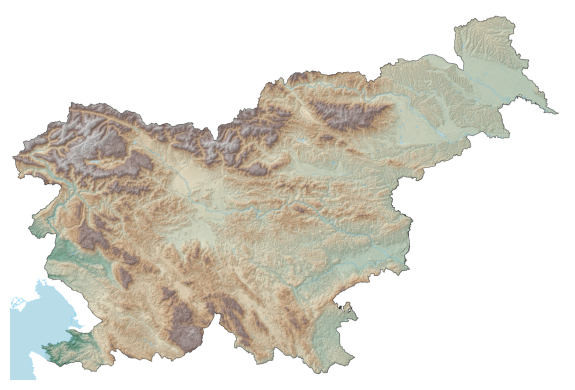

In [63]:
fig, ax = plt.subplots(figsize=(7,4))
im = ax.imshow(dsimage)
ax.set_axis_off()
plt.tight_layout()
plt.savefig("output/final_water_sea_dem_mpl_small.png", dpi=300)

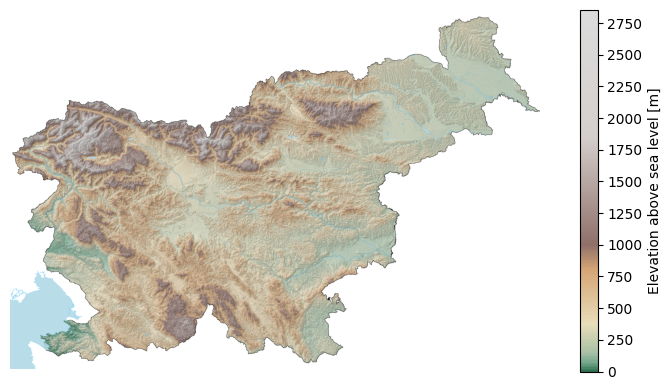

In [64]:
fig, ax = plt.subplots(figsize=(7,4))
im = ax.imshow(dsimage)
norm = Normalize(vmin=0, vmax=agg_clipped.max())
sm = ScalarMappable(norm=norm, cmap=terrain_cmap)
cbar = fig.colorbar(sm, ax=ax, ticks=[0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750])
cbar.set_label('Elevation above sea level [m]')
ax.set_axis_off()
plt.tight_layout()
plt.savefig("output/final_water_sea_dem_mpl.png", dpi=500)